## LIBRARIES

In [ ]:
import pandas as pd
from optbinning import Scorecard, BinningProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 
import numpy as np

Data from Homecredit Kaggle comepetition at: https://www.kaggle.com/competitions/home-credit-default-risk/data \
Here I use the first 10% of the train dataset as an example for this project. \
References: \
Credit Risk Scorecards Developing and Implementing Intelligent Credit Scoring by Naeem Siddiqi \
Binning (grouping or bucketing) is a technique to discretize the values of a continuous variable into bins (groups or buckets). Given a feature i with Bi bins and j = 1,...Bi and linear model coefficient ci the corresponding score point sij, with tij is the data transformation, then the scorepoint is given by: s_ij = c_i * t_ij \ 

Scorecard modelling comprises the use of simple interpretable linear models to make predictions.

In [ ]:
!git clone https://github.com/ynnn01/ScorecardDev.git

In [ ]:
dtf = pd.read_csv('/content/ScorecardDev/Data2.csv', low_memory=True)
dtf.set_index('SK_ID_CURR', inplace=True)
dtf.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DSR,LTV,YRS_EMPLOYED,AGE,YRS_LAST_PHONE_CHANGE,YRS_REGISTRATION,YRS_ID_PUBLISH
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
156852,0,Cash loans,F,Y,N,3,126000.0,888840.0,32053.5,675000.0,...,0.0,0.0,1.0,0.25,1.32,1.98,30.75,4.09,14.24,6.92
211489,0,Cash loans,M,Y,N,0,225000.0,360000.0,30798.0,360000.0,...,0.0,0.0,7.0,0.14,1.00,6.45,49.33,4.35,13.19,3.99
448618,0,Cash loans,F,N,Y,0,126000.0,312768.0,23382.0,270000.0,...,0.0,0.0,1.0,0.19,1.16,-1000.67,61.87,1.61,13.97,13.97
401051,0,Cash loans,F,N,N,0,225000.0,1096020.0,55962.0,900000.0,...,0.0,0.0,0.0,0.25,1.22,7.05,50.88,5.65,22.43,5.73
215007,0,Cash loans,M,N,Y,0,270000.0,1288350.0,37800.0,1125000.0,...,0.0,0.0,9.0,0.14,1.15,0.34,36.27,1.87,20.17,11.08


In [ ]:
sns.set(style='darkgrid')

def get_label(g):
  for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{}'.format(round(height)),
            ha="center", color='black')

In [ ]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30751 entries, 156852 to 236887
Columns: 128 entries, TARGET to YRS_ID_PUBLISH
dtypes: float64(72), int64(40), object(16)
memory usage: 30.3+ MB


## Building the Scorecard


This is the factors left after the MFA process -  Multifactors authentication \
From the factors pool after performing SFA, we use CORR matrix, there might be some highly correlated variables -> only choose some of them to avoid multicolinearity\ After the CORR matrix, the factors are grouped into group with common characteristic and the groups will be combined into scenarios of 2,3 or 4 groups per scenarios. Then we will perform MFA by logit regression and the final scenarios/ factors will be choosen by AUC index

In [ ]:
#The choosen factors after performing MFA
df_application = dtf[['TARGET','LTV',
    'CODE_GENDER',
    'YRS_EMPLOYED',
    'NAME_EDUCATION_TYPE',
    'YRS_ID_PUBLISH',
    'NAME_INCOME_TYPE',
    'YRS_LAST_PHONE_CHANGE',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'TOTALAREA_MODE']].copy()
    

EDA - Data Visualization

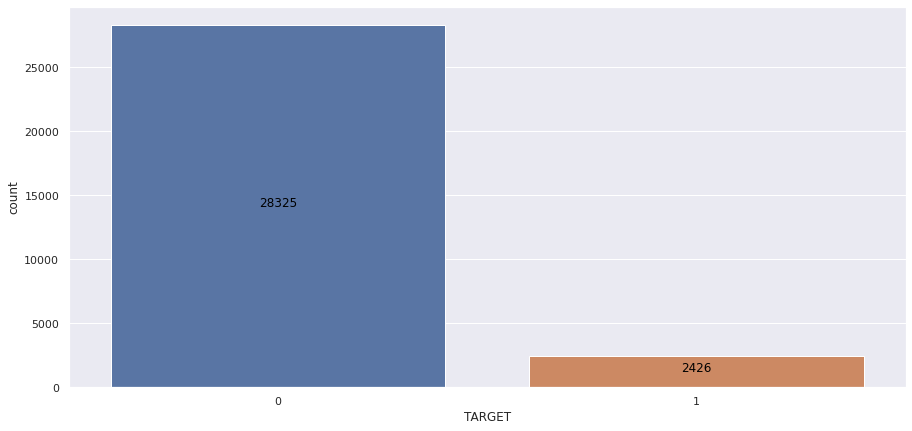

In [ ]:
plt.figure(figsize=(15,7))
g = sns.countplot(x='TARGET', data=df_application);
get_label(g)

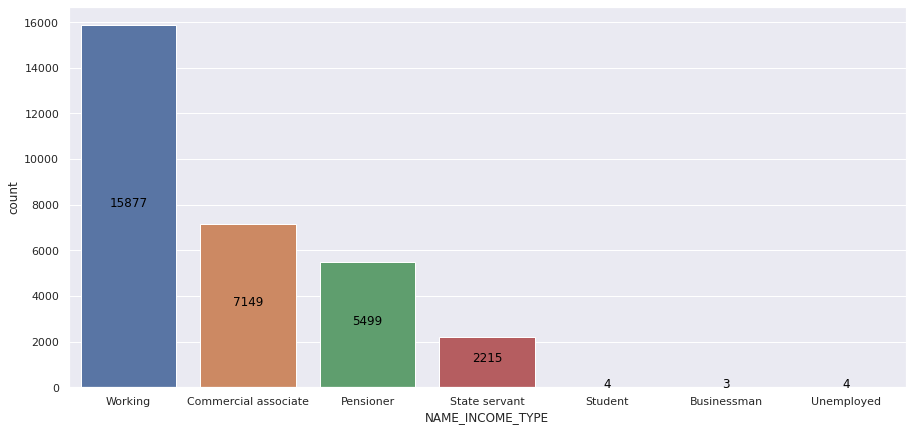

In [ ]:
plt.figure(figsize=(15,7))
g = sns.countplot(x='NAME_INCOME_TYPE', data=df_application);
get_label(g)

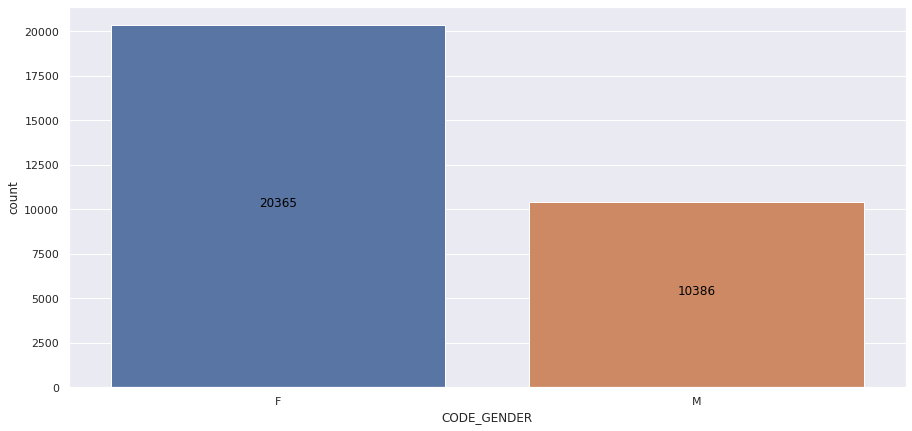

In [ ]:
plt.figure(figsize=(15,7))
g = sns.countplot(x='CODE_GENDER', data=df_application);
get_label(g)

In [ ]:
df_application.describe()

,TARGET,LTV,YRS_EMPLOYED,YRS_ID_PUBLISH,YRS_LAST_PHONE_CHANGE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TOTALAREA_MODE
count,30751.000000,30729.000000,30751.000000,30751.000000,30751.000000,13420.000000,30678.000000,24571.000000,15930.000000
mean,0.078892,1.123100,-173.633590,8.204303,2.632236,0.503591,0.513248,0.510888,0.100840
std,0.269574,0.123301,386.117558,4.139123,2.250995,0.210780,0.190691,0.195163,0.103529
min,0.000000,0.150000,-1000.670000,0.000000,0.000000,0.015600,0.000010,0.000527,0.000000
25%,0.000000,1.000000,0.800000,4.700000,0.760000,0.334983,0.391704,0.370650,0.041200
50%,0.000000,1.120000,3.360000,8.930000,2.080000,0.509856,0.564618,0.535276,0.068600
75%,0.000000,1.200000,7.610000,11.780000,4.280000,0.676260,0.662309,0.670652,0.124950
max,1.000000,2.670000,46.960000,17.160000,11.070000,0.951624,0.855000,0.896010,1.000000


Split the dataset into test & train dataset

In [ ]:
x = df_application.drop(columns=["TARGET"])
y = df_application["TARGET"]

In [ ]:
import sklearn.model_selection as model_selection

In [ ]:
x_train, x_test, y_train, y_test=model_selection.train_test_split(x,y,test_size=0.2,random_state=200)

In [ ]:
x_train.dtypes.value_counts()

float64    8
object     3
dtype: int64

In [ ]:
x_train.select_dtypes(include='object')

,CODE_GENDER,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE
SK_ID_CURR,,,
169441,F,Higher education,Working
213783,M,Higher education,Commercial associate
107857,F,Secondary / secondary special,Working
263459,F,Secondary / secondary special,Working
281898,F,Secondary / secondary special,Working
...,...,...,...
169548,F,Higher education,Working
337397,M,Secondary / secondary special,State servant
266571,F,Secondary / secondary special,State servant


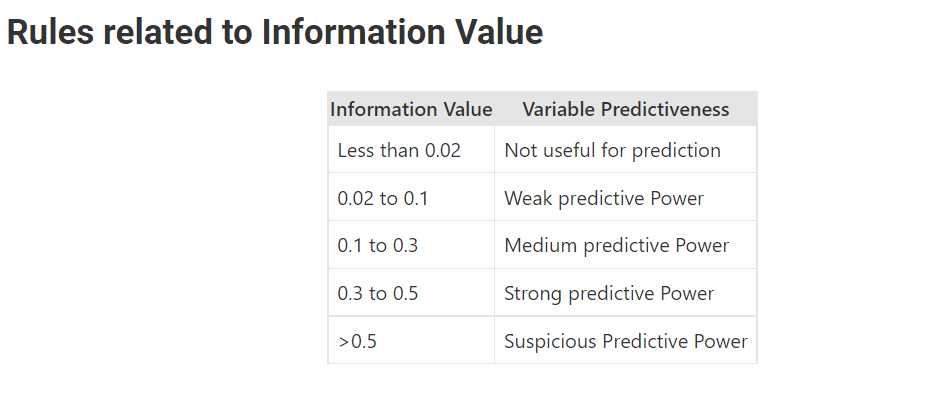 \
Another parameter we need to set at this stage is the selection_criteria , the constraints to use to define the optimal bins. Here I use the "Information Value" - IV: Σ(%Good-%Bad)×WOE
Where: WOE = ln(Good/Bad) = -logOdd since the logOdd choosen was: ln(Bad/Good)

In [ ]:
list_features = x_train.columns.values
list_categorical = x_train.select_dtypes(include=['object', 'category']).columns.values
selection_criteria = {"iv": {"min": 0.005, 'max':0.5, "strategy": "highest"}}

In [ ]:
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_features,
    selection_criteria=selection_criteria,
)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
logreg = LogisticRegression(C=3, max_iter=1000, random_state=161)

Scaling method

In [ ]:
scaling_method = "pdo_odds"
scaling_method_data = {"pdo": 20, "odds": 50, "scorecard_points": 600}
scorecard = Scorecard(
    binning_process=binning_process,
    estimator=logreg,
    scaling_method=scaling_method,
    scaling_method_params=scaling_method_data,
    intercept_based=True,
)

scorecard.fit(x_train,y_train)

Scorecard(binning_process=BinningProcess(categorical_variables=array(['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE'],
      dtype=object),
                                         selection_criteria={'iv': {'max': 0.5,
                                                                    'min': 0.005,
                                                                    'strategy': 'highest'}},
                                         variable_names=array(['LTV', 'CODE_GENDER', 'YRS_EMPLOYED', 'NAME_EDUCATION_TYPE',
       'YRS_ID_PUBLISH', 'NAME_INCOME_TYPE', 'YRS_LAST_PHONE_CHANGE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TOTALAREA_MODE'],
      dtype=object)),
          estimator=LogisticRegression(C=3, max_iter=1000, random_state=161),
          intercept_based=True, scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 20,
                                 'scorecard_points': 600})

In [ ]:
scorecard_summary = scorecard.table(style="detailed").round(3)
scorecard_summary

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,LTV,0,"(-inf, 1.10)",10642,0.433,9968,674,0.063,0.258,0.026,0.003,-0.712,16.822
1,LTV,1,"[1.10, 1.13)",3717,0.151,3478,239,0.064,0.241,0.008,0.001,-0.712,16.490
2,LTV,2,"[1.13, 1.19)",3019,0.123,2751,268,0.089,-0.108,0.001,0.000,-0.712,9.320
3,LTV,3,"[1.19, 1.21)",2051,0.083,1864,187,0.091,-0.137,0.002,0.000,-0.712,8.716
4,LTV,4,"[1.21, 1.25)",1849,0.075,1658,191,0.103,-0.275,0.006,0.001,-0.712,5.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,TOTALAREA_MODE,3,"[0.10, 0.13)",1318,0.054,1230,88,0.067,0.201,0.002,0.000,-0.693,8.612
4,TOTALAREA_MODE,4,"[0.13, 0.21)",1596,0.065,1511,85,0.053,0.442,0.011,0.001,-0.693,13.417
5,TOTALAREA_MODE,5,"[0.21, inf)",1407,0.057,1342,65,0.046,0.591,0.016,0.002,-0.693,16.408
6,TOTALAREA_MODE,6,Special,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.693,4.592


In [ ]:
scorecard.table(style="summary")

,Variable,Bin,Points
0,LTV,"(-inf, 1.10)",16.822409
1,LTV,"[1.10, 1.13)",16.490466
2,LTV,"[1.13, 1.19)",9.319541
3,LTV,"[1.19, 1.21)",8.716279
4,LTV,"[1.21, 1.25)",5.875216
...,...,...,...
3,TOTALAREA_MODE,"[0.10, 0.13)",8.611808
4,TOTALAREA_MODE,"[0.13, 0.21)",13.416855
5,TOTALAREA_MODE,"[0.21, inf)",16.407548
6,TOTALAREA_MODE,Special,4.592086


In [ ]:
from optbinning.scorecard.plots import plot_ks, plot_auc_roc

In [ ]:
x_test.loc[:,"predict_proba"] = scorecard.predict_proba(x_test)[:, 1]
x_test.loc[:,"score"] = scorecard.score(x_test)

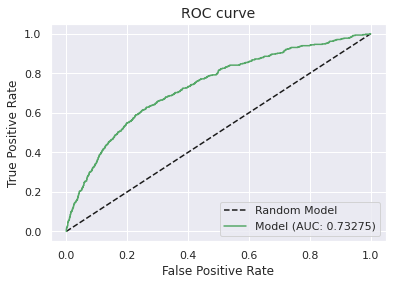

In [ ]:
plot_auc_roc(y_test, x_test.score, savefig=True, fname='scorecard_rocauc_plot.jpeg', dpi=100)
plot_auc_roc(y_test, x_test.predict_proba)

## OPTBINNING FROM THE ORIGINAL DATA

Here I will use the original first 10% of Home Credit train dataset, without the choosen factors from the pre-made MFA \
Split the dataset with test size = 0.2, randomstate=200 

In [ ]:
x2 = dtf.drop(columns=["TARGET"])
y2 = dtf["TARGET"]

In [ ]:
x2_train, x2_test, y2_train, y2_test=model_selection.train_test_split(x2,y2,test_size=0.2,random_state=200)

In [ ]:
x2_train.dtypes.value_counts()

float64    72
int64      39
object     16
dtype: int64

In [ ]:
x2_train.select_dtypes(include='object')

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
SK_ID_CURR,,,,,,,,,,,,,,,,
169441,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Single / not married,Municipal apartment,NaN,THURSDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
213783,Cash loans,M,Y,Y,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,NaN,SATURDAY,Business Entity Type 3,not specified,block of flats,"Stone, brick",No
107857,Cash loans,F,N,N,Unaccompanied,Working,Secondary / secondary special,Single / not married,Municipal apartment,Cleaning staff,THURSDAY,Business Entity Type 3,NaN,block of flats,Panel,No
263459,Cash loans,F,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Sales staff,FRIDAY,Self-employed,reg oper spec account,block of flats,Panel,No
281898,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,SATURDAY,Business Entity Type 1,reg oper account,block of flats,"Stone, brick",No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169548,Cash loans,F,Y,N,Unaccompanied,Working,Higher education,Married,House / apartment,Accountants,THURSDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
337397,Cash loans,M,Y,N,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,Core staff,WEDNESDAY,Military,org spec account,block of flats,Panel,No
266571,Cash loans,F,N,Y,"Spouse, partner",State servant,Secondary / secondary special,Married,Office apartment,NaN,SATURDAY,Business Entity Type 2,reg oper account,block of flats,"Stone, brick",No


Binning process

In [ ]:
list_features2 = x2_train.columns.values
list_categorical2 = x2_train.select_dtypes(include=['object', 'category']).columns.values
selection_criteria = {"iv": {"min": 0.005, 'max':0.5, "strategy": "highest"}}

In [ ]:
binning_process = BinningProcess(
    categorical_variables=list_categorical2,
    variable_names=list_features2,
    selection_criteria=selection_criteria,
)

In [ ]:
scaling_method = "pdo_odds"
scaling_method_data = {"pdo": 20, "odds": 50, "scorecard_points": 600}
scorecard2 = Scorecard(
    binning_process=binning_process,
    estimator=logreg,
    scaling_method=scaling_method,
    scaling_method_params=scaling_method_data,
    intercept_based=True,
)

scorecard2.fit(x2_train,y2_train)

Scorecard(binning_process=BinningProcess(categorical_variables=array(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSM...
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'DSR',
       'LTV', 'YRS_EMPLOYED', 'AGE', 'YRS_LAST_PHONE_CHANGE',
       'YRS_REGISTRATION', 'YRS_ID_PUBLISH'], dtype=object)),
          estimator=LogisticRegression(C=3, max_iter=1000, random_state=161),
          intercept_based=True, scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 20,
                                 'scorecard_points': 600})

In [ ]:
scorecard_summary = scorecard2.table(style="detailed").round(3)
scorecard_summary

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,NAME_CONTRACT_TYPE,0,[Revolving loans],2405,0.098,2267,138,0.057,0.363,0.011,0.001,0.200,0.000
1,NAME_CONTRACT_TYPE,1,[Cash loans],22195,0.902,20354,1841,0.083,-0.033,0.001,0.000,0.200,2.286
2,NAME_CONTRACT_TYPE,2,Special,0,0.000,0,0,0.000,0.000,0.000,0.000,0.200,2.094
3,NAME_CONTRACT_TYPE,3,Missing,0,0.000,0,0,0.000,0.000,0.000,0.000,0.200,2.094
0,CODE_GENDER,0,[F],16265,0.661,15110,1155,0.071,0.135,0.011,0.001,-0.771,8.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,YRS_ID_PUBLISH,5,"[11.19, 11.56)",1239,0.050,1143,96,0.077,0.041,0.000,0.000,0.320,3.998
6,YRS_ID_PUBLISH,6,"[11.56, 13.47)",5619,0.228,5263,356,0.063,0.257,0.014,0.002,0.320,2.000
7,YRS_ID_PUBLISH,7,"[13.47, inf)",1336,0.054,1267,69,0.052,0.474,0.010,0.001,0.320,0.000
8,YRS_ID_PUBLISH,8,Special,0,0.000,0,0,0.000,0.000,0.000,0.000,0.320,4.374


In [ ]:
scorecard2.table(style="summary")

,Variable,Bin,Points
0,NAME_CONTRACT_TYPE,[Revolving loans],0.000000
1,NAME_CONTRACT_TYPE,[Cash loans],2.285876
2,NAME_CONTRACT_TYPE,Special,2.093543
3,NAME_CONTRACT_TYPE,Missing,2.093543
0,CODE_GENDER,[F],8.042716
...,...,...,...
5,YRS_ID_PUBLISH,"[11.19, 11.56)",3.997945
6,YRS_ID_PUBLISH,"[11.56, 13.47)",2.000415
7,YRS_ID_PUBLISH,"[13.47, inf)",0.000000
8,YRS_ID_PUBLISH,Special,4.374233


In [ ]:
x2_test.loc[:,"predict_proba"] = scorecard2.predict_proba(x2_test)[:, 1]
x2_test.loc[:,"score"] = scorecard2.score(x2_test)

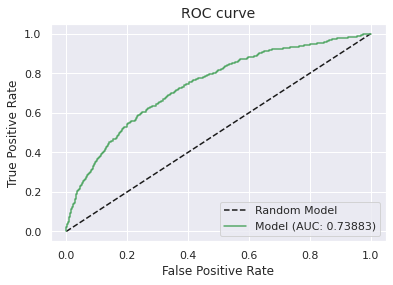

In [ ]:
plot_auc_roc(y2_test, x2_test.score, savefig=True, fname='scorecard2_rocauc_plot.jpeg', dpi=100)
plot_auc_roc(y2_test, x2_test.predict_proba)